In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf

import sys
import os
sys.path.append(os.path.abspath('./src'))
from model import *
from transformer import *
from evaluation import *

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

data_root = './data/sanity_datasets/'

# 1: Sanity check [one time series]

## 1.A: Preprocess

In [2]:
'''
Simple sequential datasets:
https://datamarket.com/data/set/22u3/international-airline-passengers-monthly-totals-in-thousands-jan-49-dec-60#!ds=22u3&display=line
https://datamarket.com/data/set/v8m/births-by-months-18532014#!ds=v8m&display=line
'''
sanity_df = pd.read_csv(
    data_root + 'births-by-months-18532014.csv',
    usecols=[1],
    engine='python',
    skipfooter=3,
    names='y',
    skiprows=[0]
)

In [3]:
# Train, Test split
train_prop = 0.66
num_obs = sanity_df.shape[0]

dataset = sanity_df[:int(train_prop * num_obs)].values
train_mean = np.mean(dataset)
train_std = np.std(dataset)

dataset = dataset.astype('float64')
dataset = (dataset-train_mean)/train_std

In [4]:
train_df = pd.DataFrame(data = np.squeeze(np.transpose(np.array([dataset[0:-2],dataset[1:-1]]))),
                        columns = ['x','y'])

transf = Transformer()
transf.fit(train_df)
scaled_train_df = transf.transform(train_df)

x_vals = np.expand_dims(np.expand_dims(np.array(scaled_train_df['x']),axis=1),axis=0)
y_vals = np.expand_dims(np.expand_dims(np.array(scaled_train_df['y']),axis=1),axis=0)

## 1.B: Train

In [5]:
# Params
num_epoch = 400
batch_size = 1
num_feat = 1
lstm_size = 32
fc_hidd_size = 16
lr = 1e-3

M = Model(num_feat=num_feat, lstm_size=lstm_size, fc_hidd_size=fc_hidd_size, lr=lr)
session = tf.Session()
session.run(tf.global_variables_initializer())

history = []
for i_epoch in range(num_epoch):
    loss = M.train_on_batch(
        sequence=x_vals,
        sequence_length=np.array([x_vals.shape[1]]),
        sequence_targets=y_vals,
        target_mask=np.ones_like(y_vals),
        session=session
    )
    history.append(loss)
    if i_epoch % 40 == 0:
        print(loss)

0.90108776294
0.343416655953
0.281946668233
0.131579230602
0.118853732622
0.115185602252
0.112129600483
0.109865808888
0.107727451311
0.105791747501


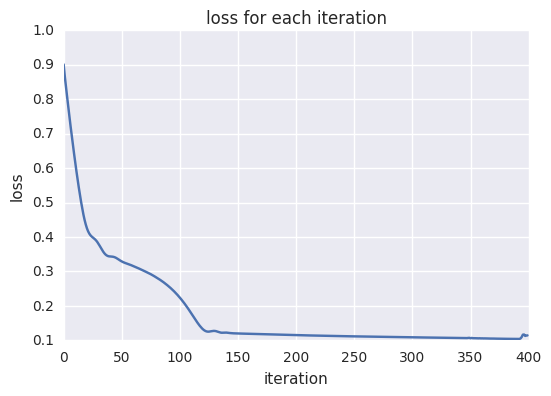

In [6]:
# plot loss
plt.plot(history)
plt.title("loss for each iteration")
plt.xlabel("iteration")
plt.ylabel("loss")

## 1.C: Visualize

In [7]:
test_dataset = sanity_df.values
test_dataset = test_dataset.astype('float32')

test_dataset = (test_dataset-train_mean)/train_std

In [8]:
test_df = pd.DataFrame(data = np.squeeze(np.transpose(np.array([test_dataset[0:-2],test_dataset[1:-1]]))),
                       columns = ['x','y'])
scaled_test_df = transf.transform(test_df)
test_x_vals = np.expand_dims(np.expand_dims(np.array(scaled_test_df['x']),axis=1),axis=0)
test_y_vals = np.expand_dims(np.expand_dims(np.array(scaled_test_df['y']),axis=1),axis=0)

In [9]:
pred, _ = M.predict_on_batch(
    sequence=test_x_vals,
    sequence_length=np.array([test_x_vals.shape[1]]),
    session=session
)

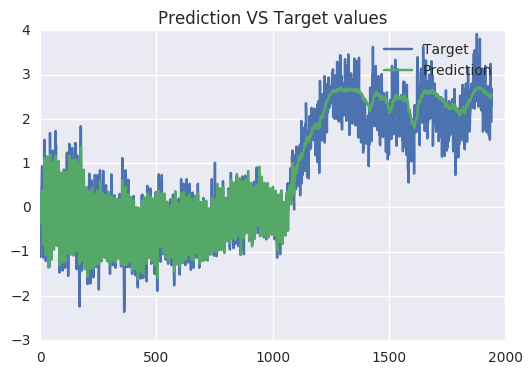

In [10]:
# plot loss
plt.title("Prediction VS Target values")
plt.plot(test_y_vals[0])
plt.plot(pred[0])
plt.legend(['Target', 'Prediction'])

In [11]:
score(test_y_vals[0,:,0], pred[0,:,0])

0.95273049316614977